## Imports

In [1]:
import math

import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics

## Load data

In [2]:
data_xlsx = pd.ExcelFile('factors.xlsx')
data_all_df = pd.read_excel(data_xlsx, 0)
data_all_df.reset_index(drop=True, inplace=True)
data_xlsx.close()
data_all_df

,year,ebike_sales,co2_per_cpt,ev_sales,pop,gas_price
0,2000,NaN,9.669214,NaN,58892514.0,NaN
1,2001,NaN,9.780857,NaN,59119673.0,NaN
2,2002,NaN,9.439251,NaN,59370479.0,NaN
3,2003,NaN,9.582911,NaN,59647577.0,77.287333
4,2004,NaN,9.557823,NaN,59987905.0,81.894003
5,2005,NaN,9.445230,NaN,60401206.0,90.820266
6,2006,98.0,9.338998,NaN,60846820.0,95.179094
7,2007,173.0,9.134187,NaN,61322463.0,97.112432
8,2008,279.0,8.825938,NaN,61806995.0,117.556702
9,2009,422.0,7.938317,NaN,62276270.0,104.146614


In [6]:
ebike_sales_df = data_all_df[['year', 'ebike_sales']]
ebike_sales_df.columns = ['year', 'y']
ebike_sales_df = ebike_sales_df[6:20]
ebike_sales_df

,year,y
6,2006,98.0
7,2007,173.0
8,2008,279.0
9,2009,422.0
10,2010,588.0
11,2011,716.0
12,2012,854.0
13,2013,907.0
14,2014,1139.0
15,2015,1364.0


## Graphing & Pre-Analysis

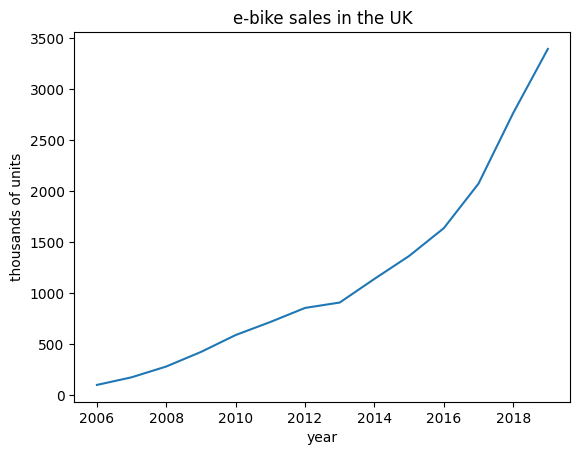

In [7]:
ebike_gr = ebike_sales_df.plot(x='year', y='y', ylabel='thousands of units', title='e-bike sales in the UK', legend=None)

In [8]:
_ = ebike_gr.figure
_.figure.set_figwidth(8)
_.figure.set_figheight(6)
_.savefig('ebike.png', bbox_inches='tight', dpi=330)

## Simple Bi variate Analysis

In [8]:
def bivariate_stats(x: pd.Series, y: pd.Series):
    _pmcc = x.corr(y)
    _covr = x.cov(y)

    print(
            f'PMCC: {_pmcc} \n'
            f'r^2:  {_pmcc ** 2} \n'
            f'Cov:  {_covr}'
    )


def univariate_graphs(x: pd.Series):
    pd.plotting.autocorrelation_plot(x)
    plt.show()


def linear_reg_func(m: LinearRegression):
    _coef = m.coef_[0][0]
    _itcp = m.intercept_[0]
    print(f'Linear Regressed: y = {_coef}x {"+" if abs(_itcp) == _itcp else "-"} {abs(_itcp)}')

PMCC: 0.9386622865497584 
r^2:  0.8810868881908207 
Cov:  3895.5


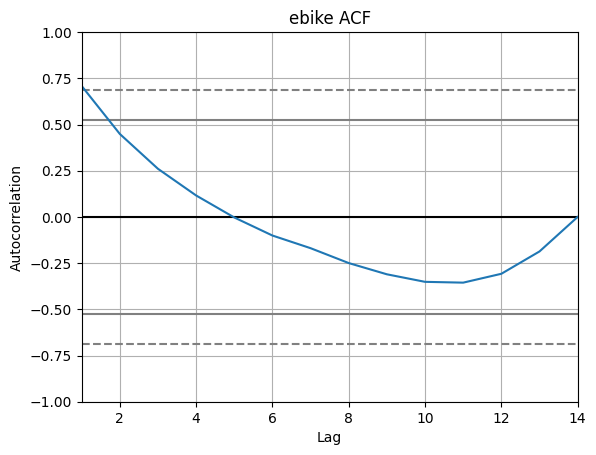

In [10]:
bivariate_stats(ebike_sales_df['year'], ebike_sales_df['y'])
_ = pd.plotting.autocorrelation_plot(ebike_sales_df['y'])
_.set_title('ebike ACF')

_ = plt.figure(1, figsize=(8, 6))

plt.show()

# _.savefig('co2_acf.png', bbox_inches='tight', dpi=330)

## Forecasting

In [11]:
PRED_YEARS = pd.DataFrame(range(2006, 2029))
PRED_YEARS.columns = ['year']

In [12]:
PRED_YEARS_PROPHET = PRED_YEARS.copy()
PRED_YEARS_PROPHET.columns = ['ds']
PRED_YEARS_PROPHET['ds'] = pd.to_datetime(PRED_YEARS_PROPHET['ds'], format='%Y')

In [13]:
def error_stats(x: pd.Series, y: pd.Series):
    _mse = metrics.mean_squared_error(x, y)
    _mae = metrics.mean_absolute_error(x, y)
    _mape = metrics.mean_absolute_percentage_error(x, y)
    _r2 = metrics.r2_score(x, y)

    print(
            f'MSE:  {_mse} \n'
            f'RMSE: {math.sqrt(_mse)} \n'
            f'R^2:  {_r2} \n'
            f'MAE:  {_mae} \n'
            f'MAPE: {_mape}%'
    )

### Linear

In [15]:
def line_func(x, a, b):
    return a * x + b

In [16]:
m_ebike_lr = LinearRegression()

m_ebike_lr.fit(ebike_sales_df[['year']], ebike_sales_df[['y']])
pmt_ebike_lr = [m_ebike_lr.coef_, m_ebike_lr.intercept_]

ebike_pred_lr = m_ebike_lr.predict(PRED_YEARS)
ebike_pred_lr = pd.DataFrame(ebike_pred_lr)
ebike_pred_lr.columns = ['y']

In [18]:
bivariate_stats(ebike_sales_df['y'], ebike_pred_lr['y'])
error_stats(ebike_sales_df['y'], ebike_pred_lr['y'][:14])

PMCC: 0.9386622865497588 
r^2:  0.8810868881908215 
Cov:  867138.2999999989
MSE:  108671.25714285942 
RMSE: 329.65323772543087 
R^2:  0.881086888190818 
MAE:  268.8285714285739 
MAPE: 0.5446618453954509%


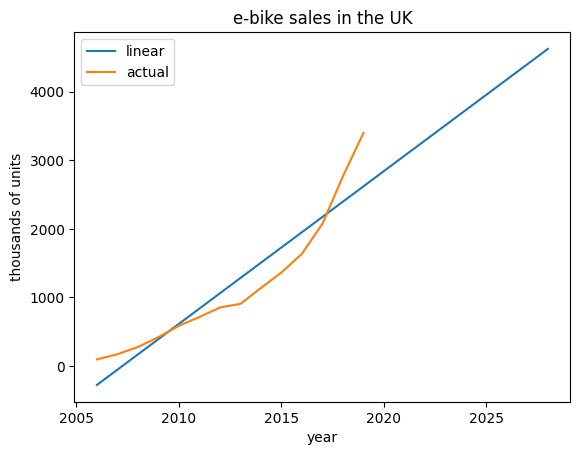

In [19]:
plt.plot(PRED_YEARS, ebike_pred_lr, label='linear')
plt.plot(ebike_sales_df['year'], ebike_sales_df['y'], label='actual')
plt.title('e-bike sales in the UK')
plt.ylabel('thousands of units')
plt.xlabel('year')
plt.legend()
_ = plt.figure(1, figsize=(8, 6))
plt.show()

# _.savefig('co2_line.png', bbox_inches='tight', dpi=330)

### Exponential

In [20]:
from scipy.optimize import curve_fit


In [21]:
def exp_func(x, a, b, c):
    return 2 ** ((x + a) * b) + c

In [25]:
pmt_ebike_exp, cov = curve_fit(exp_func, ebike_sales_df['year'], ebike_sales_df['y'], p0=[-2000, 0.3, 10])
print(pmt_ebike_exp)

[-1.98176882e+03  3.14491416e-01  9.42261206e+00]


In [26]:
ebike_pred_exp = exp_func(PRED_YEARS, *pmt_ebike_exp)
ebike_pred_exp.columns = ['y']

In [29]:
bivariate_stats(ebike_sales_df['y'], ebike_pred_exp['y'])
error_stats(ebike_sales_df['y'], ebike_pred_exp['y'][:14])

print(f'Exponential Regressed: y = e^((x - {abs(pmt_ebike_exp[0]):.5}) * {pmt_ebike_exp[1]:.5}) + {pmt_ebike_exp[2]:.5}')

PMCC: 0.9964181056955657 
r^2:  0.9928490413579395 
Cov:  3613940.1005257275
MSE:  6535.054491352855 
RMSE: 80.83968388949116 
R^2:  0.9928490413579393 
MAE:  69.98432482341698 
MAPE: 0.17615099473138507%
Exponential Regressed: y = e^((x - 1981.8) * 0.31449) + 9.4226


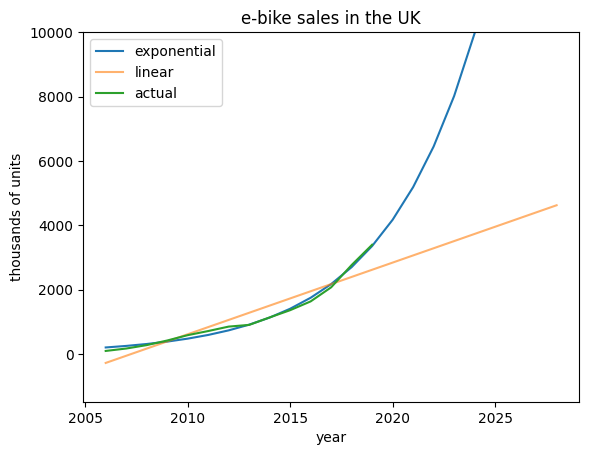

In [32]:
plt.plot(PRED_YEARS, ebike_pred_exp, label='exponential')
plt.plot(PRED_YEARS, ebike_pred_lr, label='linear', alpha=0.6)
plt.plot(ebike_sales_df['year'], ebike_sales_df['y'], label='actual')
plt.title('e-bike sales in the UK')
plt.ylabel('thousands of units')
plt.xlabel('year')
plt.ylim(top=10_000)
plt.legend()
_ = plt.figure(1, figsize=(8, 6))
plt.show()

# _.savefig('co2_exp.png', bbox_inches='tight', dpi=330)

### Logistic

In [36]:
def logi_func(x, x0, k, d):
    return 9000 / (1 + np.exp(-k * (x - x0))) + d

In [37]:
pmt_ebike_logi, cov = curve_fit(logi_func, ebike_sales_df['year'], ebike_sales_df['y'], p0=[2021, 0.3, 140], maxfev=100_000)
print(pmt_ebike_logi)

[2.02107128e+03 2.97390445e-01 1.43515405e+02]


In [38]:
ebike_pred_logi = logi_func(PRED_YEARS, *pmt_ebike_logi)
ebike_pred_logi.columns = ['y']

In [40]:
bivariate_stats(ebike_sales_df['y'], ebike_pred_logi['y'])
error_stats(ebike_sales_df['y'], ebike_pred_logi['y'][:14])
print(
        f'Logistic Regressed: '
        f'{9000} / '
        f'(1 + '
        f'e^(-{pmt_ebike_logi[1]:.5} * (x - {pmt_ebike_logi[0]:.5}))'
        f') + {pmt_ebike_logi[2]}'
)

PMCC: 0.9630129403179725 
r^2:  0.9273939232198668 
Cov:  2072235.013477714
MSE:  10260.52213642714 
RMSE: 101.2942354550699 
R^2:  0.9887724624881666 
MAE:  88.59376670621154 
MAPE: 0.22774139287455922%
Logistic Regressed: 9000 / (1 + e^(-0.29739 * (x - 2021.1))) + 143.51540489611983


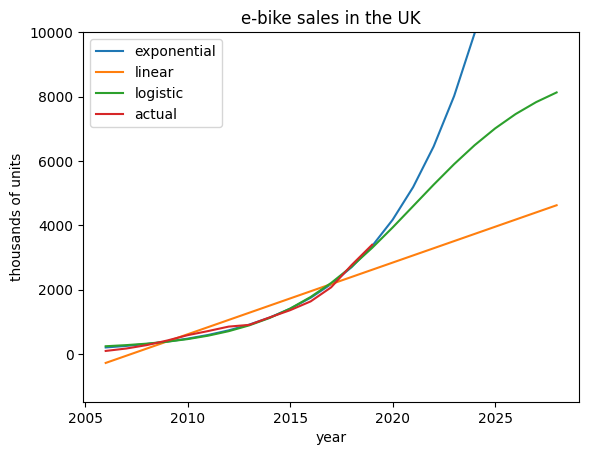

In [51]:
plt.plot(PRED_YEARS, ebike_pred_exp, label='exponential')
plt.plot(PRED_YEARS, ebike_pred_lr, label='linear')
plt.plot(PRED_YEARS, ebike_pred_logi, label='logistic')
plt.plot(ebike_sales_df['year'], ebike_sales_df['y'], label='actual')
plt.title('e-bike sales in the UK')
plt.ylabel('thousands of units')
plt.xlabel('year')
plt.ylim(top=10_000)
plt.legend()
plt.show()

### Sigmoid

In [43]:
def sigm_func(x, slope, exp, x_ctr, y_min, y_max):
    return ((x - x_ctr) / (
            slope**-exp + (2 * abs(x - x_ctr) / (y_max - y_min))**exp
    ) ** (1 / exp)) + (y_max - y_min) / 2 + y_min


optim_pmt_man = [1111, 1.3, 2021, -630, 10_000]


def sigm_func_lim(y_max=10_000):
    def wrap(x, slope, exp, x_ctr, y_min):
        return sigm_func(x, slope, exp, x_ctr, y_min, y_max)
    return wrap

In [44]:
pmt_co2_sigm, cov = curve_fit(sigm_func_lim(), ebike_sales_df['year'], ebike_sales_df['y'], p0=optim_pmt_man[:-1], maxfev=69420)
print(pmt_co2_sigm)

[ 1.55020547e+03  8.63674382e-01  2.01970161e+03 -1.43942213e+03]


In [46]:
ebike_pred_sigm = sigm_func(PRED_YEARS, *pmt_co2_sigm, 10_000)
ebike_pred_sigm.columns = ['y']

In [47]:
bivariate_stats(ebike_sales_df['y'], ebike_pred_sigm['y'])
error_stats(ebike_sales_df['y'], ebike_pred_sigm['y'][:14])

PMCC: 0.9306114330005536 
r^2:  0.8660376392313439 
Cov:  2288553.0568179833
MSE:  3474.4206284881657 
RMSE: 58.94421624288651 
R^2:  0.9961981283779168 
MAE:  52.17049344089407 
MAPE: 0.09766028855297333%


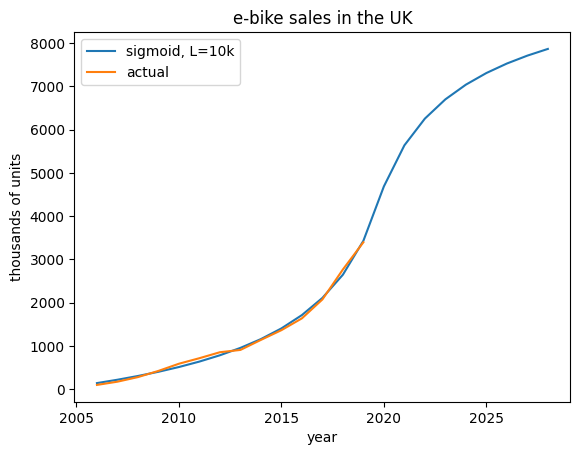

In [50]:
plt.plot(PRED_YEARS, ebike_pred_sigm, label='sigmoid, L=10k')
plt.plot(ebike_sales_df['year'], ebike_sales_df['y'], label='actual')
plt.title('e-bike sales in the UK')
plt.ylabel('thousands of units')
plt.xlabel('year')
plt.legend()
_ = plt.figure(1, figsize=(8, 6))
plt.show()

# _.savefig('co2_sigm_565.png', bbox_inches='tight', dpi=330)

### Tilted Sigmoid

In [66]:
def tilted_sig_func(x):
    x_ctr = 2019.26
    slope = 690.991
    y_min = 2030.02
    y_max = 7000.
    exp = 2.01
    t = 83.

    return ((x - x_ctr) / (
            slope**-exp + (2 * abs(x - x_ctr) / (y_max - y_min))**exp
    ) ** (1 / exp)) + (y_max - y_min) / 2 + y_min + t * x - t * y_min

In [67]:
ebike_pred_ts = tilted_sig_func(PRED_YEARS)
ebike_pred_ts.columns = ['y']
ebike_pred_ts

,y
0,121.517138
1,218.194417
2,318.352497
3,423.238296
4,534.685568
5,655.459264
6,789.838276
7,944.614047
8,1130.789048
9,1366.299960


In [68]:
bivariate_stats(ebike_sales_df['y'], ebike_pred_ts['y'])
error_stats(ebike_sales_df['y'], ebike_pred_ts['y'][:14])

PMCC: 0.925556452254392 
r^2:  0.8566547463097366 
Cov:  1867078.4087197946
MSE:  1796.0666289855421 
RMSE: 42.38002629760324 
R^2:  0.998034660889323 
MAE:  36.45047672277308 
MAPE: 0.07303338233866845%


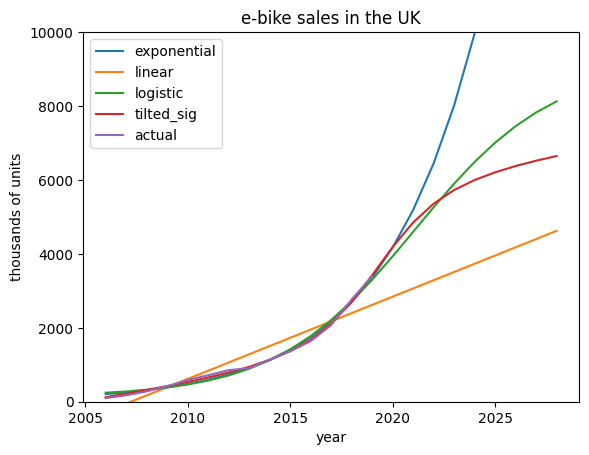

In [70]:
plt.plot(PRED_YEARS, ebike_pred_exp, label='exponential')
plt.plot(PRED_YEARS, ebike_pred_lr, label='linear')
plt.plot(PRED_YEARS, ebike_pred_logi, label='logistic')
plt.plot(PRED_YEARS, ebike_pred_ts, label='tilted_sig')
plt.plot(ebike_sales_df['year'], ebike_sales_df['y'], label='actual')
plt.title('e-bike sales in the UK')
plt.ylabel('thousands of units')
plt.xlabel('year')
plt.ylim(bottom=0, top=10_000)
plt.legend()
plt.show()
